**Insights**
* The big problem I'm trying to solve here is to make the relatively complex system of NNs for NLP something I cant 'wrap my head around'
    * It's about learning, and one of the critical concepts in human learning is 'chunking'. So I've got three layers here: 
        * Top: "string of text" ==(NN system)==> username of interest [Y/N]
        * Second: Collection of scripts with input/knobs/dials/outputs
        * Third: Code itself, presented as close to linearly as possible
        * Important to not try going too deep (I made this mistake with bash tools). Once you've got some solid abstractions that give you flexibility and don't seem to leak, extend rather than deepening knowledge
    * Connections to concrete concepts that I already know are also key, so making the inputs/outputs clear in examples using Python datatypes that I'm comfortable with will help grasp the abstract transforms 
    * Reenforcement is key, so I'll try to copy this and apply it to a different problem almost as soon as I'm done
    * The problem with many other systems is that, in an admirable effort to be modular, they force you to jump 3-7 levels deep within functions to get to the actual Python code (the concrete concept). From the main script, it can take several minutes to trace how an input and parameter actually get combined into an output.
        * Even if effort was made to document, there's a "curse of knowledge" issue that makes it difficult to grasp the particulars without the mental model that the original writer had
    * Goal is to find the mental models where I can look at other people's output (code), break it down quickly and accurately, identify what's new about it, and how i could update my design process to take advantage of anything that I don't yet have
        * [This twitter thread](https://twitter.com/michael_nielsen/status/1074150124169773056) talks about meeting 'magicians' who are better in ways that you can't comprehend, then working to understand the implicit models that allow them to be 10x better. You probably can't do it just from their work, you need to communicate on a more abstract level. How do I do that here?
    * Get solid on one simple approach, and then identify ways to extend it that I don't fully understand yet. Nailing down specific questions, "I would have expected X, but I'm seeing Y - what's going on?" is critical
* There's huge value in having a single file where you can see everything, whether it's a diagram, makefile or Jupyter notebook
* Need to identify what needs to be flexible. Passing a trivial amount of data e2e should be very doable. Then building on that, so that the data is essentially flowing (not moving in massive blocks)
* From a documentation standpoint, unit tests waste too much time on the edge cases. At the very least, the top test should always be 'happy path' so you can see what it _should_ look like. Then there needs to be a connection between files
    * This is much more possible for data pipelines than application code, so it's under-developed
* One big thing that I think I lack is an intuitive sense of what's "expensive", in terms of Disk, IO, RAM and Compute (are there other limited resources?)
    * Is streaming data from a server going to be a bottleneck?
    * Is it computationally expensive to open a bunch of little data files, instead of one big one?

In [1]:
###
# META
###

import h5py

DATADIR = '/home/mritter/code/twitter_nlp/sandbox_data02/'
NUM_SAMPLES = 10
SKIP_FIRST = 1000

In [2]:
# download_data.py

# Input
manifest_filename = 'manifest.txt'
server_url = 'https://files.pushshift.io/hackernews/'

# Knobs
test_pct = .5

# Output
raw_data = 'raw_data'


from requests import get
import bz2, json, tqdm
import numpy as np

np.random.seed = 42
stop = False
sample_l = []
with open(DATADIR+manifest_filename) as infile:
    for line in tqdm.tqdm(infile):  # Dial
        remote_filename = line.split()[1]
        print(remote_filename)
        as_bytes = get(server_url+remote_filename+'.bz2').content
        as_text = bz2.decompress(as_bytes)
        for sample in as_text.split(b'\n'):
            if not len(sample): continue
            sample_l.append(sample.decode("ascii", "ignore"))
            if len(sample_l) >= (SKIP_FIRST + NUM_SAMPLES):
                stop = True
            if stop: break
        print(len(sample_l))
        if stop: break
            
sample_l = sample_l[SKIP_FIRST:]
np.random.shuffle(sample_l)

0it [00:00, ?it/s]

HNI_2006-10


1it [00:00,  3.16it/s]

61
HNI_2006-12


2it [00:00,  3.33it/s]

62
HNI_2007-02
1010


In [3]:
print(sample_l[0])
print('== shuffling ==')
np.random.seed = 42
np.random.shuffle(sample_l)
print(sample_l[0])

{"by":"phil","id":1003,"parent":955,"retrieved_on":1525542114,"text":"8.3% of what they did in 2005: wow.","time":1172399687,"type":"comment"}
== shuffling ==
{"by":"rms","descendants":10,"id":1007,"kids":[1025],"retrieved_on":1525542114,"score":9,"time":1172404841,"title":"What algorithm does news.YC use to filter spam?","type":"story"}


In [4]:
test_ix = int(len(sample_l)*test_pct)

with open(DATADIR+raw_data+'_train.jsonl', 'w') as outfile:
    outfile.write('\n'.join(sample_l[test_ix:]))
        
with open(DATADIR+raw_data+'_test.jsonl', 'w') as outfile:
    outfile.write('\n'.join(sample_l[:test_ix]))

In [5]:
! ls -lah sandbox_data/*jsonl

-rw-rw-r-- 1 mritter mritter 1016 Jan 26 20:59 sandbox_data/raw_data_test.jsonl
-rw-rw-r-- 1 mritter mritter 2.1K Jan 26 20:59 sandbox_data/raw_data_train.jsonl


In [6]:
! wc -l sandbox_data/*jsonl

   4 sandbox_data/raw_data_test.jsonl
   4 sandbox_data/raw_data_train.jsonl
   8 total


In [7]:
! head sandbox_data/*jsonl

==> sandbox_data/raw_data_test.jsonl <==
{"by":"phil","id":1003,"parent":955,"retrieved_on":1525542114,"text":"8.3% of what they did in 2005: wow.","time":1172399687,"type":"comment"}
{"by":"python_kiss","descendants":0,"id":1002,"retrieved_on":1525542114,"score":2,"time":1172397259,"title":"The Battle for Mobile Search","type":"story","url":"http:\/\/www.businessweek.com\/technology\/content\/feb2007\/tc20070220_828216.htm?campaign_id=rss_daily"}
{"by":"volida","id":1010,"parent":856,"retrieved_on":1525542115,"text":"Ebay bought its Chinese clone for hundreds of millions of dollars","time":1172413027,"type":"comment"}
{"by":"msgbeepa","descendants":0,"id":1008,"retrieved_on":1525542115,"score":1,"time":1172410393,"title":"Great Way To Find New Job And Career","type":"story","url":"http:\/\/www.wikio.com\/webinfo?id=13628228"}
{"by":"python_kiss","descendants":0,"id":1001,"retrieved_on":1525542114,"score":3,"time":1172396128,"title":"Wireless: India's Hot, China's Not","type":"story","

In [8]:
# preprocess_txt.py

# Input
raw_data = 'raw_data_train.jsonl'

# Knobs
status = 'training'
filter_bool = ('type', 'comment') 
split_regex = r' |\.'
remove_regex = r"\'|\"|,|\.|\n"
tag_patterns = {'http.*\w':' <LINK> '}
positive_labels = ('pg', 'patio11', 'volida')
sequence_length = 300

# Output
preprocessed_data = 'preprocessed.txt'
label_file = 'label_and_index.h5'

import re

labels = []
original_ids = []

with open(DATADIR+raw_data, 'r') as infile:
    with open(DATADIR+preprocessed_data, 'w') as outfile:
        for line in tqdm.tqdm(infile):  # Dial
            line_json = json.loads(line)

            if line_json[filter_bool[0]] != filter_bool[1]: continue
            temp_text = line_json['text']
            temp_text = temp_text.lower()
            for key, value in tag_patterns.items():
                temp_text = re.sub(key, value, temp_text)
            text = re.split(split_regex, re.sub(remove_regex, '', temp_text))
            print(len(text))
            text += ['']*(sequence_length-len(text))
            text += ['\n']
            outfile.write(','.join(text))
            
            if status == 'training':
                labels.append((1, 0) if line_json['by'] in positive_labels else (0, 1))  # Not generalizable
                original_ids.append(line_json['id'])
            
if status == 'training':
    with h5py.File(DATADIR+label_file, "w") as f:
        f.create_dataset('training_labels', (len(labels), 2), dtype='int', data=labels)
        f.create_dataset('ordered_keys', (len(original_ids), 1), dtype='int', data=original_ids)
    

5it [00:00, 5212.91it/s]

83
11
8


In [9]:
!head -2 sandbox_data/preprocessed.txt

ebay,bought,its,chinese,clone,for,hundreds,of,millions,of,dollars,which,afterwards,collapsed,because,after,moving,the,servers,outside,china,the,services,data,were,going,through,word,filtering,(eg,during,login),and,there,were,failures,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,have,it,so,you,can,be,automatically,logged,in,i,have,to,manually,log,in,every,time,i,visit,the,site,(using,safari,here)<p>2,just,like,reddit,does,show,the,domain,each,link,belongs,to,reddit,has,this,in,brackets,after,the,headline,which,works,fine,since,i,dont,have,much,free,time,there,are,some,sites,that,have,sub-par,content,which,i,avoid,reading,and,it,helps,to,know,where,i,would,end,up,without,having,to,hover,over,the,link,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

_insight_: w2v is generated with a simple NN autoencoder

In [11]:
# train_w2v.py

# Input
preprocessed_data = 'preprocessed.txt'

#Knobs
embedding_dim = 2

# Output
w2v_weights_and_word_index_mapping = 'w2v_weights_and_word_index_mapping.h5'

class W2VIter:
    def __init__(self, texts):
        self.texts = texts
    def __iter__(self):
        for text in self.texts:
            yield [token for token in text.split(',') if token != '']

with open(DATADIR+preprocessed_data, 'r') as f:
    w2viter = W2VIter(f.read().split('\n'))

import logging
from gensim.models import Word2Vec

logger= logging.getLogger()
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

w2v = Word2Vec(w2viter, iter=1, min_count=1, size=embedding_dim, workers=2)

2019-01-26 22:00:00,869 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-01-26 22:00:00,870 : INFO : collecting all words and their counts
2019-01-26 22:00:00,871 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-01-26 22:00:00,871 : INFO : collected 79 word types from a corpus of 102 raw words and 4 sentences
2019-01-26 22:00:00,872 : INFO : Loading a fresh vocabulary
2019-01-26 22:00:00,873 : INFO : min_count=1 retains 79 unique words (100% of original 79, drops 0)
2019-01-26 22:00:00,873 : INFO : min_count=1 leaves 102 word corpus (100% of original 102, drops 0)
2019-01-26 22:00:00,874 : INFO : deleting the raw counts dictionary of 79 items
2019-01-26 22:00:00,875 : INFO : sample=0.001 downsamples 79 most-common words
2019-01-26 22:00:00,875 : INFO : downsampling leaves estimated 35 word corpus (35.2% of prior 102)
2019-01-26 22:00:00,876 : INFO : estimated required memory for 79 words and 2 dimensions: 40764 bytes

In [12]:
w2v.wv.vocab.keys()

dict_keys(['1', 'have', 'it', 'so', 'you', 'can', 'be', 'automatically', 'logged', 'in', 'i', 'to', 'manually', 'log', 'every', 'time', 'visit', 'the', 'site', '(using', 'safari', 'here)<p>2', 'just', 'like', 'reddit', 'does', 'show', 'domain', 'each', 'link', 'belongs', 'has', 'this', 'brackets', 'after', 'headline', 'which', 'works', 'fine', 'since', 'dont', 'much', 'free', 'there', 'are', 'some', 'sites', 'that', 'sub-par', 'content', 'avoid', 'reading', 'and', 'helps', 'know', 'where', 'would', 'end', 'up', 'without', 'having', 'hover', 'over', 'ebay', 'bought', 'its', 'chinese', 'clone', 'for', 'hundreds', 'of', 'millions', 'dollars', '83%', 'what', 'they', 'did', '2005:', 'wow'])

In [13]:
print(w2v.wv['you'][:5])
print(w2v.wv.index2word[0], w2v.wv.index2word[1], w2v.wv.index2word[2])
print('Index of "you" is: {}'.format(w2v.wv.vocab['you'].index))
w2v.save(DATADIR+"myw2v.w2v")
w2v_loaded = Word2Vec.load(DATADIR+"myw2v.w2v")
print('Index of "you" is: {}'.format(w2v_loaded.wv.vocab['you'].index))

2019-01-26 22:00:00,979 : INFO : saving Word2Vec object under /home/mritter/code/twitter_nlp/sandbox_data02/myw2v.w2v, separately None
2019-01-26 22:00:00,980 : INFO : not storing attribute vectors_norm
2019-01-26 22:00:00,980 : INFO : not storing attribute cum_table
2019-01-26 22:00:00,981 : INFO : saved /home/mritter/code/twitter_nlp/sandbox_data02/myw2v.w2v
2019-01-26 22:00:00,982 : INFO : loading Word2Vec object from /home/mritter/code/twitter_nlp/sandbox_data02/myw2v.w2v
2019-01-26 22:00:00,983 : INFO : loading wv recursively from /home/mritter/code/twitter_nlp/sandbox_data02/myw2v.w2v.wv.* with mmap=None
2019-01-26 22:00:00,983 : INFO : setting ignored attribute vectors_norm to None
2019-01-26 22:00:00,984 : INFO : loading vocabulary recursively from /home/mritter/code/twitter_nlp/sandbox_data02/myw2v.w2v.vocabulary.* with mmap=None
2019-01-26 22:00:00,984 : INFO : loading trainables recursively from /home/mritter/code/twitter_nlp/sandbox_data02/myw2v.w2v.trainables.* with mmap=N

[ 0.21018033 -0.18125333]
i have in
Index of "you" is: 13
Index of "you" is: 13


In [14]:
l = []
for i, token in enumerate(w2v.wv.index2word): l.append(w2v.wv[token])
weights = np.array(l)
print(weights.shape)
weights[:5, :5]

(79, 2)


array([[-0.03932533,  0.18881728],
       [ 0.1273874 , -0.08095149],
       [-0.21662496,  0.07357214],
       [-0.18276599, -0.16205968],
       [-0.03800876,  0.00189891]], dtype=float32)

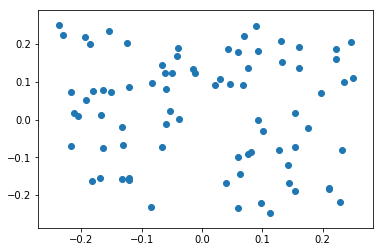

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(weights[:, 0], weights[:, 1])

In [16]:
import h5py

with h5py.File(DATADIR+w2v_weights_and_word_index_mapping, "w") as f:
    f.create_dataset('weights', weights.shape, dtype='f', data=weights)
    for word in w2v.wv.vocab.keys():
        f.create_dataset('word_to_index/{}'.format(word), (1,), dtype='int', data=w2v.wv.vocab[word].index)
    f.create_dataset('metadata/embedding_dim', (1,), dtype='int', data=embedding_dim)
    f.create_dataset('metadata/max_token', (1,), dtype='int', data=weights.shape[0]+1)
    f.create_dataset('metadata/sequence_length', (1,), dtype='int', data=sequence_length)

In [17]:
with h5py.File(DATADIR+w2v_weights_and_word_index_mapping, "r") as f:
    print(list(f['word_to_index'].keys())[:5])
    print(f['word_to_index']['you'][()])

['(using', '1', '2005:', '83%', 'after']
[13]


In [27]:
# index_text.py

# loading_dock: [local] train text, [local] gensim
# shipping_dock: [local] text as indexes, [local] 100d w2v array sorted with that index
# TODO should I bring the w2v sorting into here?
# TODO I need to think about how IDs get passed around here

# Input
w2v_weights_and_word_index_mapping = 'w2v_weights_and_word_index_mapping.h5'
preprocessed_data = 'preprocessed.txt'

# Knobs
pass

# Output 
indexed_filename = 'indexed.h5'

with h5py.File(DATADIR+w2v_weights_and_word_index_mapping, "r") as index:
    with open(DATADIR+preprocessed_data, "r") as textfile:
        
        text_lines = textfile.read().split('\n')
        indexed = np.zeros(shape=(len(text_lines)-1, index['metadata']['sequence_length'].value[0]))
        keys = index['word_to_index'].keys()
        for line_ix, wordlist in enumerate(text_lines):
            for word_ix, word in enumerate(wordlist.split(',')):
                if word in keys:
                    indexed[line_ix, word_ix] = index['word_to_index'][word][()]
        
    print(indexed[0, :5])

    with h5py.File(DATADIR+indexed_filename, "w") as f:
        f.create_dataset('training_data', 
                         indexed.shape, 
                         dtype='int', data=indexed)

[11.  1.  6. 12. 13.]


In [28]:
# # Write outputs
# with h5py.File(DATADIR+"indexed.h5", "w") as f:
#     f.create_dataset('training_data', (len(indexed_texts), 300), dtype='int', data=list(indexed_texts.values()))
# #     f.create_dataset('ordered_keys', (len(indexed_texts), 1), dtype='int', data=list(indexed_texts.keys()))
# #     f.create_dataset('max_token', (1,), dtype='int', data=weights.shape[0]+1)
# #     f.create_dataset('sequence_length', (1,), dtype='int', data=sequence_length)

In [29]:
# Try reading
with h5py.File(DATADIR+indexed_filename, "r") as f:
    print(f['training_data'][-1])
#     print(f['ordered_keys'][:2])
#     print(f['sequence_length'][0])


[73  5 74 75 76  2 77 78  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]


In [30]:
# model.py

# loading_dock: 100d w2v array, datafile
# lever: params
# dial: model.summary()
# shipping_dock: [local] compiled model

w2v_weights_and_word_index_mapping = 'w2v_weights_and_word_index_mapping.h5'
training_file = 'indexed.h5'
compiled_model = 'compiled_model.keras'

# with h5py.File(DATADIR+training_file, "r") as f:
#     max_token = f['max_token'][0]
#     sequence_length = f['sequence_length'][0]

with h5py.File(DATADIR+w2v_weights_and_word_index_mapping, "r") as f:
    embedding_matrix = f['weights'][()]
    embedding_dim = f['metadata/embedding_dim'][0]
    num_distinct_words = f['metadata/max_token'][0]
    sequence_length = f['metadata/sequence_length'][0]
    
from keras.models import Sequential
from keras.layers import Dense, Input, Embedding, Flatten
from keras.initializers import Constant
from keras.models import Model


sequence_input = Input(shape=(sequence_length,), dtype='int32')

embedded_sequences = Embedding(num_distinct_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=False)(sequence_input)

x = Dense(units=64, activation='relu')(embedded_sequences)
x = Dense(units=32, activation='relu')(embedded_sequences)
x = Flatten()(x)
preds = Dense(units=2, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

print(model.summary())
model.save(DATADIR+compiled_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 300, 2)            160       
_________________________________________________________________
dense_5 (Dense)              (None, 300, 32)           96        
_________________________________________________________________
flatten_2 (Flatten)          (None, 9600)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 19202     
Total params: 19,458
Trainable params: 19,298
Non-trainable params: 160
_________________________________________________________________
None


In [31]:
# train.py

# loading_dock: [local] text as indexes, [local] compiled model
# lever: epocs
# dial: tensorboard
# shipping_dock: [local] saved model

training_file = 'indexed.h5'
label_file = 'label_and_index.h5'

compiled_model = 'compiled_model.keras'
trained_model = 'trained_model.yaml'
trained_weights = 'trained_weights.h5'

from keras.callbacks import TensorBoard as tb
from datetime import datetime
t = datetime.now()
tensorboard = tb(log_dir='tensorboard_logs/{:%Y-%m-%d-%H-%M}'.format(t))

with h5py.File(DATADIR+training_file, "r") as f1:
    with h5py.File(DATADIR+label_file, "r") as f2:
        x_train = f1['training_data']  # Note that Keras is special in being able to read the HDF5 _object_
        y_train = f2['training_labels']
        
        model.fit(x_train, y_train,
                  batch_size=64, #128,
                  epochs=2,
                  shuffle='batch',  # Required for using HDF5
#                   validation_data=(x_val, y_val),
                  callbacks=[tensorboard])

# serialize model to YAML
# From https://machinelearningmastery.com/save-load-keras-deep-learning-models/
model_yaml = model.to_yaml()
with open(DATADIR+trained_model, "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights(DATADIR+trained_weights)
print("Saved model to disk")


Epoch 1/2
3/3 [==============================] - 0s 84ms/step - loss: 0.6898 - acc: 0.6667
Epoch 2/2
3/3 [==============================] - 0s 2ms/step - loss: 0.6824 - acc: 0.6667
Saved model to disk


In [37]:
from keras.models import model_from_yaml
# load YAML and create model
yaml_file = open(DATADIR+trained_model, 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights(DATADIR+trained_weights)
print("Loaded model from disk")


Loaded model from disk


In [38]:
# inference.py

# loading_dock: candidate comment
# processing: call preprocess and index, then apply model
# shipping_dock: best comment

comment_text = """
Reminder, if you're in the US, the FTC says your eye doctor must give you your prescription after your exam. If a doctor refuses to do so, they can face legal action and penalties.

https://www.consumer.ftc.gov/blog/2016/05/buying-prescriptio...

That said, I don't think the FTC stipulates what information must appear on the prescription. Many docs leave off your PD (pupillary distance), which is a necessary measurement if you're buying online. Fortunately, there are a variety of easy ways to take this measurement yourself after the exam, although if you're really concerned about precision, you'll want the doctor's measurement.

And by the way, it should go without saying, but I'll say it anyway. Although the quality of eyewear available online can be comparable to what you'd get in store ... please don't think an online eye exam is an acceptable substitute for visiting an ophthalmologist in person and getting a comprehensive eye exam! 
"""

trained_model = 'trained_model.yaml'
trained_weights = 'trained_weights.h5'


from keras.models import model_from_yaml

# load YAML and create model
with open(DATADIR+trained_model, 'r') as yaml_file:
    loaded_model_yaml = yaml_file.read()
    loaded_model = model_from_yaml(loaded_model_yaml)

# load weights into new model
loaded_model.load_weights(DATADIR+trained_weights)
print("Loaded model from disk")


indexed_texts = []
for word in comment_text.lower().split():
    if word in w2v.wv.vocab:
        a = w2v.wv.vocab[word].index
    else:
        a = 0
    indexed_texts.append(a)
    
indexed_texts += [0]*(sequence_length-len(indexed_texts))
asarray = np.array([indexed_texts])
loaded_model.predict(asarray)

Loaded model from disk


array([[0.47513252, 0.5248675 ]], dtype=float32)

In [ ]:
# test.py

# loading_dock: [local] test file
# processing: call inference, then compare to labels 
# shipping_dock: accuracy printout

test_filename = 'downloaded_test'
trained_model = 'trained_model'